# From Attention to transformers


In this tutorial, our focus is on delving into the intricacies of the attention mechanism. If you're keen on it, you'll be able to create a self-attention layer and construct your own transformer model from skatch.

In many well-established libraries like **torch**, the code tends to be somewhat challenging to decipher due to efficiency optimizations and the inclusion of various conditional paths using **if** and **else**. Here, we will craft **a more intelligible yet functionally equivalent model** and verify its performance against the official implementation.



### General note for GPU training (in colab)

* First, please use the GPU runtime. If so the `!nvidia-smi` will return no error.
  1. Click on "Runtime" in the top menu bar.
  2. Select "Change runtime type" from the drop-down menu.
  3. In the "Runtime type" section, select "GPU" as the hardware accelerator.
  4. Click "Save" to apply the changes.


* What should I do with **Cuda out of memory error.**? (this is THE most common error in DL)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*enMsxkgJ1eb9XvtWju5V8Q.png)
  1. In colab notebook, **unfortunately, you need to restart the kernel after OOM happened**. Or it will keep happening no matter what.
  2. Change the model to save memory, usually includes, decrease batch size, decrease the number of layers, decrease the max sequence length, decrease the hidden / embedding dimension
  3. If you know mixed precision training, you can switch to low precision `fp16` numbers for weights and inputs.

* What should I do for the **Device siee assert triggered** error
  > RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
  
  * Usually it's because the embedding layer receive an index (token id or position id) not stored in it.
  * Could be sth. else, which will be harder to debug...

In [248]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8" # to fix a potential locale bug
!nvidia-smi

Thu Feb 22 15:41:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   31C    P0    68W / 300W |   7628MiB /  7629MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [249]:
!pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [250]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Self-Attention Mechanism: Single Head

![](https://raw.githubusercontent.com/Animadversio/TransformerFromScratch/main/media/AttentionSchematics_white-01.png)

In [251]:
#Attention heads 4 with headdim 64 ----> 64*4 = 256(embdim)

embdim = 256 #Embedding dimension -Size of vector representing each token
headdim = 64 #Attention head dimension - Size of the vectors used in each individual attention head

#Generates a tensor sampled from std normal dist(randn)
   #Batch size -1, we are processing 1 sample at a time
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
#Weight matrix for queries
Wq = torch.randn(embdim, headdim) / math.sqrt(embdim)
#Weight matrix for keys - used when it's trying to understand which words are important to pay attention to, based on the context of the question it's asking
Wk = torch.randn(embdim, headdim) / math.sqrt(embdim)
#Weight matrix for values -  When the computer has decided which words are important to focus on (using Wk), it uses Wv to grab the specific pieces of information (values) from those words to help answer the question or understand the sentence better.
Wv = torch.randn(embdim, embdim) / math.sqrt(embdim)

Fill in the score matrix computation

In [252]:
#einsum - to transform tokens to queries, keys and values vectors
qis = torch.einsum("BSE,EH->BSH", tokens, Wq) # batch x seqlen x headdim
kis = torch.einsum("BTE,EH->BTH", tokens, Wk) # batch x seqlen x headdim
vis = torch.einsum("BTE,EF->BTF", tokens, Wv) # batch x seqlen x embeddim
#scoremat =  # output: batch x seqlen (Query) x seqlen (Key)
scoremat = torch.einsum("BSH,BTH->BST", qis, kis)
#### ------ End ------ ####
attmat = F.softmax(scoremat / math.sqrt(headdim), dim=2)

Some checks to make sure the score correspond to the product of the right pair.

In [253]:
#These assertions are checks to ensure that the computation of the score matrix (scoremat) was done correctly. Each assertion compares an individual element from the scoremat tensor against a manually computed dot product between a specific query (qis) and key (kis) vector

assert(torch.isclose(scoremat[0,1,2], qis[0,1,:]@kis[0,2,:]))
assert(torch.isclose(scoremat[0,3,4], qis[0,3,:]@kis[0,4,:]))
assert(torch.isclose(scoremat[0,2,2], qis[0,2,:]@kis[0,2,:]))

In [254]:
zis = torch.einsum("BST,BTF->BSF", attmat, vis)

In pytorch, these operations are packed int the function `F.scaled_dot_product_attention`. So let's test our implementation of the single head attention against it.

In [255]:
attn_torch = F.scaled_dot_product_attention(qis,kis,vis)
assert(torch.allclose(attn_torch, zis, atol=1E-6,rtol=1E-6))

## Multi-head attention

In [256]:
embdim = 768
headcnt = 12
headdim = embdim // headcnt
assert headdim * headcnt == embdim
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
Wq = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wk = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wv = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim

In [257]:
batch, token_num, _ = tokens.shape
qis = torch.einsum("BSE,EH->BSH", tokens, Wq)
kis = torch.einsum("BTE,EH->BTH", tokens, Wk)
vis = torch.einsum("BTE,EH->BTH", tokens, Wv)
# split the single hidden dim into the heads
qis_mh = qis.view(batch, token_num, headcnt, headdim)
kis_mh = kis.view(batch, token_num, headcnt, headdim)
vis_mh = vis.view(batch, token_num, headcnt, headdim)

Now your challenge is to compute multihead attention using `einsum`

In [258]:

scoremat_mh = torch.einsum("BSCH,BTCH->BCST", qis_mh, kis_mh)
#scoremat_mh =   # Output: batch x headcnt x seqlen (query) x seqlen (key)
#### ------ End ------ ####
attmat_mh = F.softmax(scoremat_mh / math.sqrt(headdim), dim=-1)
zis_mh = torch.einsum("BCST,BTCH->BSCH", attmat_mh, vis_mh)  # batch x seqlen (query) x headcnt x headdim
zis = zis_mh.reshape(batch, token_num, headcnt * headdim)

Let's validate the tensor multiplication is correct

In [259]:
# raw attention score of the 1st attention head
assert (torch.allclose(scoremat_mh[0, 1], qis_mh[0,:,1] @ kis_mh[0,:,1,:].T))

In [260]:
print(tokens.shape)
print(qis_mh.shape)
print(kis_mh.shape)
print(vis_mh.shape)
print(attmat_mh.shape)
print(zis_mh.shape)
print(zis.shape)

torch.Size([1, 5, 768])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 12, 5, 5])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 768])


In `torch` this operation is packed in `nn.MultiheadAttention`, including the input projection, attention and out projection. So, note the input the the `mha.forward` function are the *token_embeddings* not the Q,K,Vs as we put it in `F.scaled_dot_product_attention`

In [261]:
mha = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
print(mha.in_proj_weight.shape) # 3 * embdim x embdim
mha.in_proj_weight.data = torch.cat([Wq, Wk, Wv], dim=1).T

torch.Size([2304, 768])


In [262]:
attn_out, attn_weights = mha(tokens, tokens, tokens, average_attn_weights=False,)
assert torch.allclose(attmat_mh, attn_weights, atol=1e-6, rtol=1e-6)

In `nn.MultiheadAttention` , there is a output projection `out_proj`, projecting the values. It is a linear layer with bias. We can validate that going through this projection our outputs `zis` is the same as the output of `mha`

In [263]:
print(mha.out_proj)
assert torch.allclose(attn_out, mha.out_proj(zis), atol=1e-6, rtol=1e-6)

NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)


### Causal attention mask

For models such as GPT, each token can only attend to tokens before it, thus the attention score needs to be modified before entering softmax.

The common way of masking is to add a large negative number to the locations that you'd not want the model to attend to.

In [264]:
attn_mask = torch.ones(token_num,token_num,)
attn_mask = -1E4 * torch.triu(attn_mask,1)
attn_mask

tensor([[    -0., -10000., -10000., -10000., -10000.],
        [    -0.,     -0., -10000., -10000., -10000.],
        [    -0.,     -0.,     -0., -10000., -10000.],
        [    -0.,     -0.,     -0.,     -0., -10000.],
        [    -0.,     -0.,     -0.,     -0.,     -0.]])

In [265]:
scoremat_mh_msk = torch.einsum("BSCH,BTCH->BCST", qis_mh, kis_mh)  # batch x headcnt x seqlen (query) x seqlen (key)
scoremat_mh_msk += attn_mask  # add the attn mask to the scores before SoftMax normalization
attmat_mh_msk = F.softmax(scoremat_mh_msk / math.sqrt(headdim), dim=-1)
zis_mh_msk = torch.einsum("BCST,BTCH->BSCH", attmat_mh_msk, vis_mh)  # batch x seqlen (query) x headcnt x headdim
zis_msk = zis_mh_msk.reshape(batch, token_num, headcnt * headdim)

**Note** `is_causal` parameter should work and create a causal mask automatically. But in a recent pytorch bug, it doesn't work. So beware~
https://github.com/pytorch/pytorch/issues/99282

In [266]:
attn_out_causal, attn_weights_causal = mha(tokens, tokens, tokens, average_attn_weights=False, attn_mask=attn_mask)

In [267]:
assert torch.allclose(attn_weights_causal, attmat_mh_msk, atol=1e-6, rtol=1e-6)
assert torch.allclose(attn_out_causal, mha.out_proj(zis_msk), atol=1e-6, rtol=1e-6)

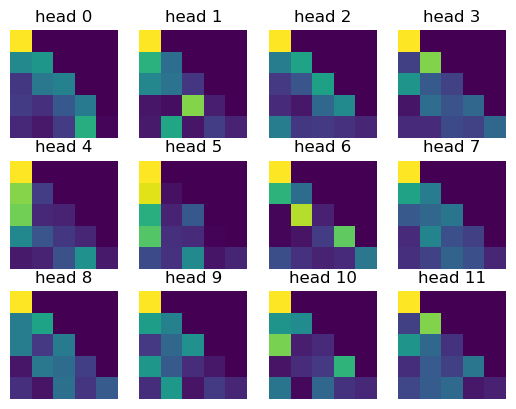

In [268]:
plt.figure()
for head in range(headcnt):
    plt.subplot(3, 4, head + 1)
    plt.imshow(attn_weights_causal[0, head].detach().numpy())
    plt.title(f"head {head}")
    plt.axis("off")
plt.show()

## Transformer Block

Having gaining some intuition about attention layer, let's build it into a transformer. An vanilla transformer block usually looks like this. Note there are slight difference between the transformer blocks in GPT2, BERT and other models, but they generally has the following components

* Transformer Block
  * Layernorm
  * Skip connections
  * Multi-head attention
  * MLP, Feedforward net


In [269]:
class TransformerBlock_simple(nn.Module):

    def __init__(self, embdim, headcnt, *args, dropout=0.0, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ln1 = nn.LayerNorm(embdim)
        self.ln2 = nn.LayerNorm(embdim)
        self.attn = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
        self.ffn = nn.Sequential(
            nn.Linear(embdim, 4 * embdim),
            nn.GELU(),
            nn.Linear(4 * embdim, embdim),
            nn.Dropout(dropout),
        )

    def forward(self, x, is_causal=True):
        batch, token_num, hidden_dim = x.shape
        if is_causal:
            attn_mask = torch.ones(token_num, token_num,)
            attn_mask = -1E4 * torch.triu(attn_mask,1)
        else:
            attn_mask = None

        residue = x
        x = self.ln1(x)
        
        attn_output, attn_weights = self.attn(x, x, x, attn_mask=attn_mask)  # first output is the output latent states
        
        x = residue + attn_output

        residue = x
        x = self.ln2(x)
        ffn_output = self.ffn(x)
        output = residue + ffn_output
        return output

Compare the implmentation with the schematics and see if it makes more sense!


*Attention Block*


![BERT (Transformer encoder)](https://iq.opengenus.org/content/images/2020/06/encoder-1.png)


# Image Classification

Now we employ Transformer structure to conduct image classification.

### Imports

In [270]:
!pip install transformers
!pip install torchvision

## Import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import BertModel, BertTokenizer, BertConfig

import os
from os.path import join
from tqdm.notebook import tqdm, trange
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, CIFAR10
from torchvision import datasets, transforms


### Preparing Image Dataset
Load the dataset, note, the augmentations are necessary. If no augmentation, Transformer will overfit very soon.

In [271]:
!mkdir data
dataset = CIFAR10(root='./data/', train=True, download=True, transform=
transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))
# augmentations are super important for CNN trainings, or it will overfit very fast without achieving good generalization accuracy
val_dataset = CIFAR10(root='./data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))
#%%

mkdir: cannot create directory ‘data’: File exists
Files already downloaded and verified
Files already downloaded and verified


Citing https://openreview.net/pdf?id=SCN8UaetXx,

> "Visual Transformers. Despite some previous work in which attention is used inside the convolutional layers of a CNN [57, 26], the first fully-transformer architectures for vision are iGPT [8] and ViT [17]. The former is trained using a "masked-pixel" self-supervised approach, similar in spirit to the common masked-word task used, for instance, in BERT [15] and in GPT [45] (see below). On the other hand, ViT is trained in a supervised way, using a special "class token" and a classification head attached to the final embedding of this token. Both methods are computationally expensive and, despite their very good results when trained on huge datasets, they underperform ResNet architectures when trained from scratch using only ImageNet-1K [17, 8]. VideoBERT [51] is conceptually similar to iGPT, but, rather than using pixels as tokens, each frame of a video is holistically represented by a feature vector, which is quantized using an off-the-shelf pretrained video classification model. DeiT [53] trains ViT using distillation information provided by a pretrained CNN."

### Transformer model for images

In [272]:
config = BertConfig(hidden_size=256, intermediate_size=1024, num_hidden_layers=12,
                    num_attention_heads=8, max_position_embeddings=256,
                    vocab_size=100, bos_token_id=101, eos_token_id=102,
                    cls_token_id=103, )
model = BertModel(config).cuda()
patch_embed = nn.Conv2d(3, config.hidden_size, kernel_size=4, stride=4).cuda()
CLS_token = nn.Parameter(torch.randn(1, 1, config.hidden_size, device="cuda") / math.sqrt(config.hidden_size))
readout = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                        nn.GELU(),
                        nn.Linear(config.hidden_size, 10)
                        ).cuda()
for module in [patch_embed, readout, model, CLS_token]:
    module.cuda()

optimizer = AdamW([*model.parameters(),
                   *patch_embed.parameters(),
                   *readout.parameters(),
                   CLS_token], lr=5e-4)

### For 10 Epochs

In [274]:
batch_size = 192 # 96
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.train()
loss_list = []
acc_list = []

for epoch in trange(10, leave=False):
    correct_cnt = 0
    total_loss = 0
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        patch_embs = patch_embed(imgs.cuda())
        
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1) # hint: (batch_size, HW, hidden)
        
       # print(patch_embs.shape) #  (192, 256, 8, 8)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
       # print(input_embs.shape)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        #print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    loss_list.append(round(total_loss / len(dataset), 4))
    acc_list.append(round(correct_cnt / len(dataset), 4))
    # test on validation set
    model.eval()
    correct_cnt = 0
    total_loss = 0

    for i, (imgs, labels) in enumerate(val_loader):
        patch_embs = patch_embed(imgs.cuda())
       
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # hint: (batch_size, HW, hidden)
       
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.7104, val acc: 0.3668


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.4079, val acc: 0.4932


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.2230, val acc: 0.5590


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.0942, val acc: 0.6075


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.0444, val acc: 0.6274


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.0060, val acc: 0.6429


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8947, val acc: 0.6789


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.9020, val acc: 0.6871


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8519, val acc: 0.7026


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7930, val acc: 0.7204


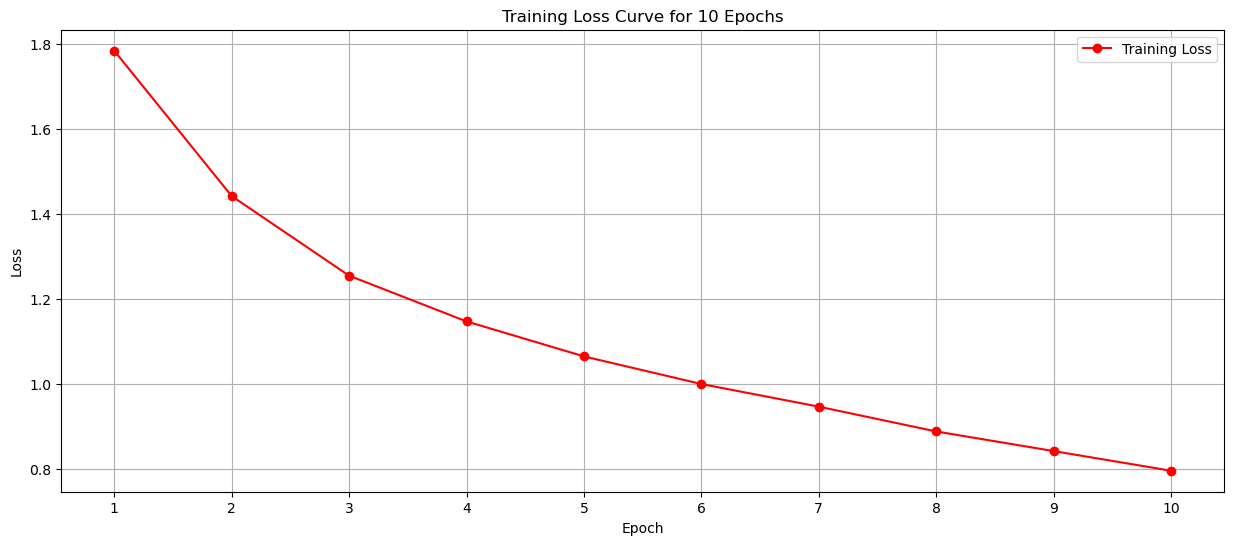

In [275]:

plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')  # Plot the training loss with epoch count
plt.title('Training Loss Curve for 10 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.xticks(range(len(loss_list)), range(1, 1+len(loss_list)))  # Ensure x-axis labels match epoch numbers
plt.legend()  # Show legend to identify the curve
plt.grid(True)
plt.legend() 

plt.show()  # Display the plot

#### ------ End ------ ####

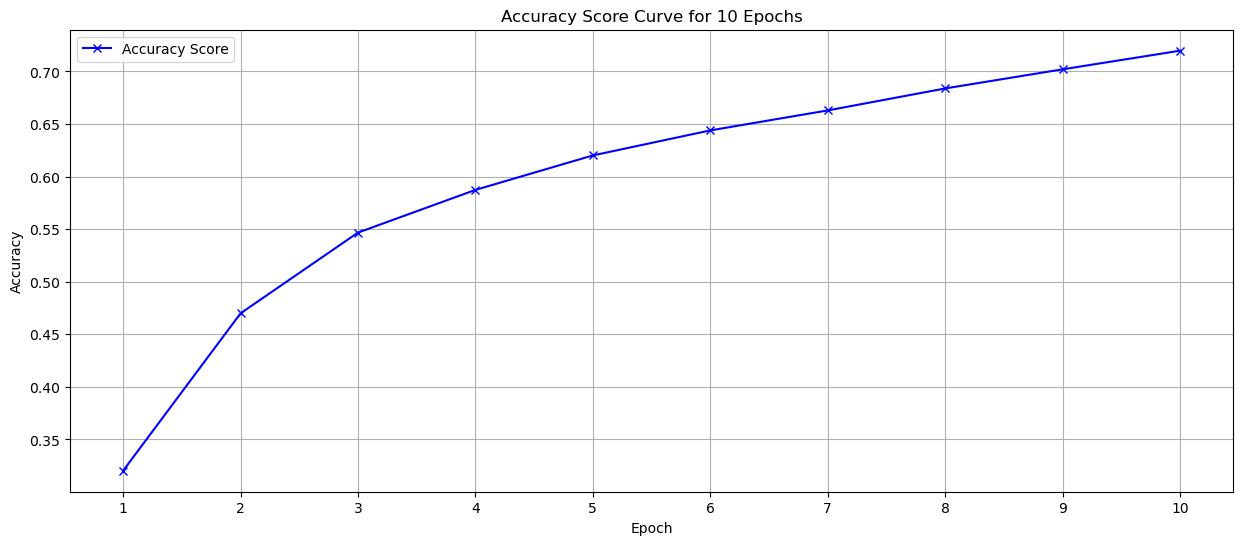

In [276]:

# Assuming 'acc_list' contains the accuracy for each epoch
plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')# Plot the training accuracy with epoch count
plt.title('Accuracy Score Curve for 10 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))  # Ensure x-axis labels match epoch numbers
plt.legend() 
plt.grid(True)  
plt.show()  # Display the plot


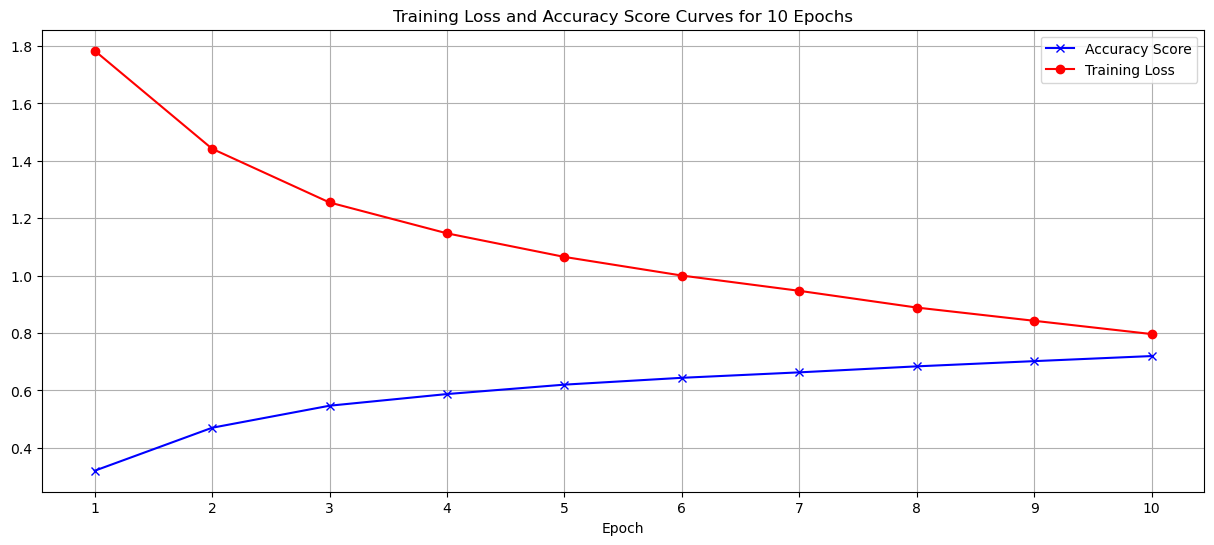

In [277]:
# Plotting Loss and Accuracy Score together
plt.figure(figsize=(15, 6))
plt.title('Training Loss and Accuracy Score Curves for 10 Epochs')
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))
plt.xlabel('Epoch')
plt.legend() 
plt.grid(True)  
plt.show()

### For 30 Epochs

In [278]:
batch_size = 192 # 96
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.train()
loss_list = []
acc_list = []
for epoch in trange(30, leave=False):
    correct_cnt = 0
    total_loss = 0
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1) # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
       # print(patch_embs.shape) #  (192, 256, 8, 8)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
       # print(input_embs.shape)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        #print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    loss_list.append(round(total_loss / len(dataset), 4))
    acc_list.append(round(correct_cnt / len(dataset), 4))
    # test on validation set
    model.eval()
    correct_cnt = 0
    total_loss = 0

    for i, (imgs, labels) in enumerate(val_loader):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8121, val acc: 0.7133


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7101, val acc: 0.7527


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7204, val acc: 0.7506


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7122, val acc: 0.7509


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6934, val acc: 0.7581


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6684, val acc: 0.7666


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6563, val acc: 0.7706


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6231, val acc: 0.7896


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6358, val acc: 0.7768


  0%|          | 0/261 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



val loss: 0.6027, val acc: 0.7929


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6008, val acc: 0.7951


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5948, val acc: 0.7963


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5883, val acc: 0.7948


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5657, val acc: 0.8077


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5894, val acc: 0.7997


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5746, val acc: 0.8081


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6089, val acc: 0.7965


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6058, val acc: 0.8064


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5858, val acc: 0.8045


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5552, val acc: 0.8166


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6251, val acc: 0.8007


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5832, val acc: 0.8161


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5782, val acc: 0.8166


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5985, val acc: 0.8160


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5844, val acc: 0.8168


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5671, val acc: 0.8207


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6007, val acc: 0.8178


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6116, val acc: 0.8142


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6101, val acc: 0.8114


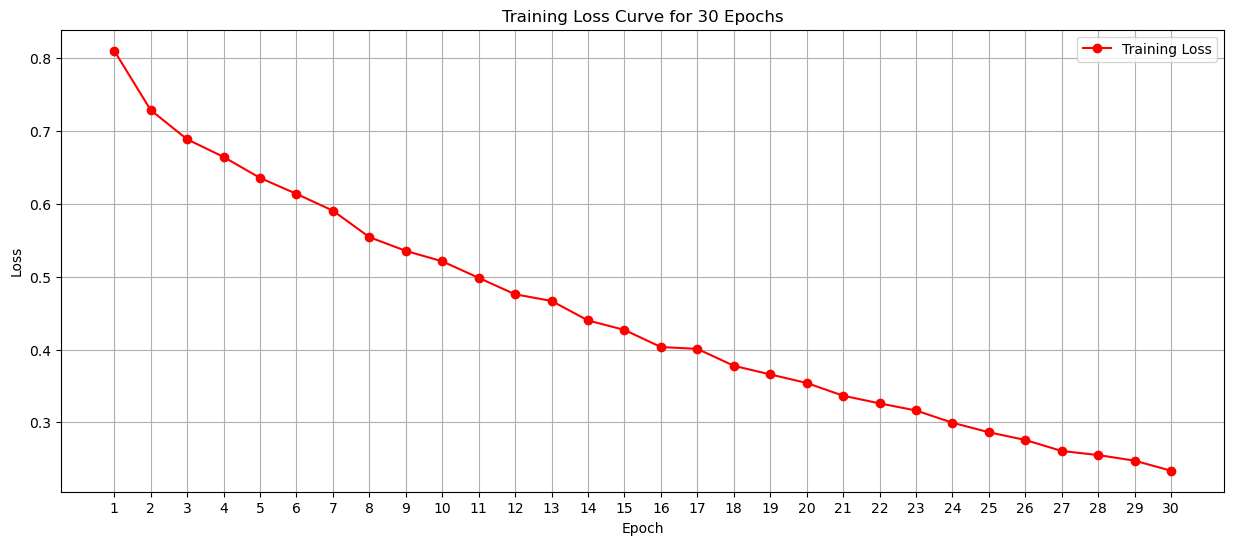

In [279]:

plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')  # Plot the training loss with epoch count
plt.title('Training Loss Curve for 30 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.xticks(range(len(loss_list)), range(1, 1+len(loss_list)))  # Ensure x-axis labels match epoch numbers
plt.legend()  # Show legend to identify the curve
plt.grid(True)
plt.legend() 

plt.show()  # Display the plot

#### ------ End ------ ####

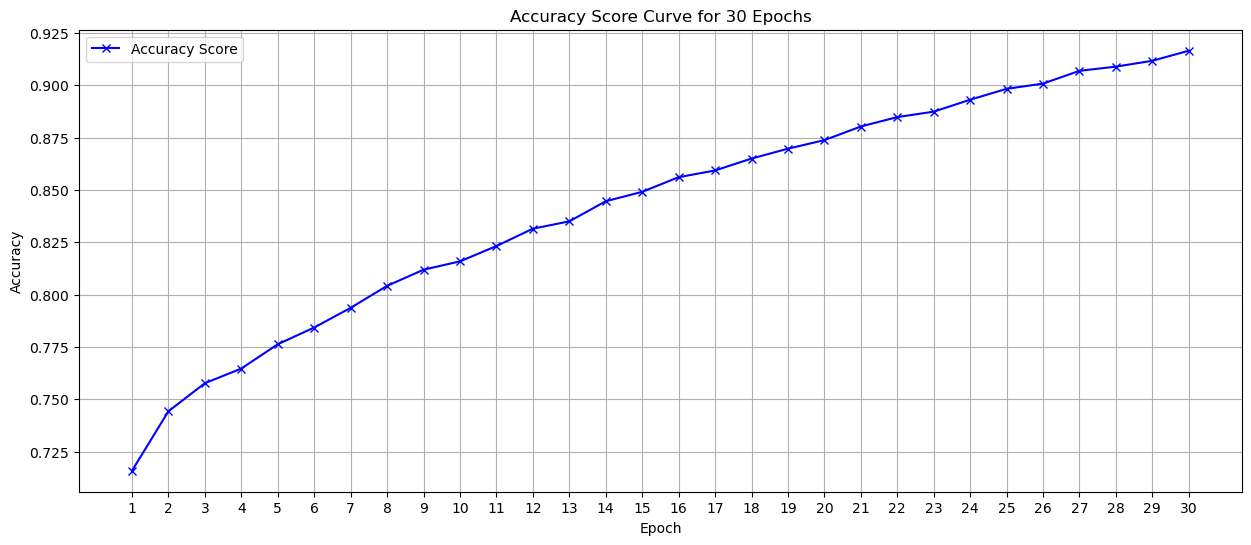

In [280]:


# Assuming 'acc_list' contains the accuracy for each epoch
plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')# Plot the training accuracy with epoch count
plt.title('Accuracy Score Curve for 30 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))  # Ensure x-axis labels match epoch numbers
plt.legend() 
plt.grid(True)  
plt.show()  # Display the plot


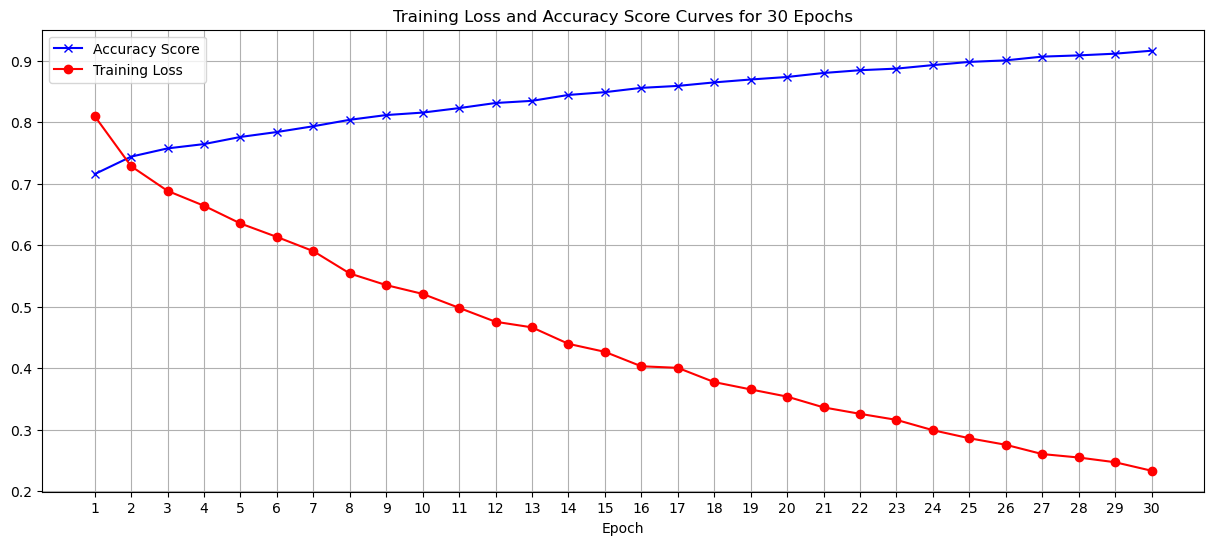

In [281]:
# Plotting Loss and Accuracy Score together
plt.figure(figsize=(15, 6))
plt.title('Training Loss and Accuracy Score Curves for 30 Epochs')
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))
plt.xlabel('Epoch')
plt.legend() 
plt.grid(True)  
plt.show()

### For 50 Epochs

In [282]:
batch_size = 192 # 96
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.train()
loss_list = []
acc_list = []

for epoch in trange(50, leave=False):
    correct_cnt = 0
    total_loss = 0
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1) # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
       # print(patch_embs.shape) #  (192, 256, 8, 8)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
       # print(input_embs.shape)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        #print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    loss_list.append(round(total_loss / len(dataset), 4))
    acc_list.append(round(correct_cnt / len(dataset), 4))
    # test on validation set
    model.eval()
    correct_cnt = 0
    total_loss = 0

    for i, (imgs, labels) in enumerate(val_loader):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5891, val acc: 0.8250


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5942, val acc: 0.8259


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6232, val acc: 0.8204


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6506, val acc: 0.8153


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6363, val acc: 0.8158


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6518, val acc: 0.8119


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6663, val acc: 0.8133


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6516, val acc: 0.8169


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6499, val acc: 0.8224


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6357, val acc: 0.8270


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6959, val acc: 0.8103


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6535, val acc: 0.8183


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6474, val acc: 0.8166


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6838, val acc: 0.8138


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6829, val acc: 0.8183


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7049, val acc: 0.8129


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6740, val acc: 0.8174


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6716, val acc: 0.8226


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6827, val acc: 0.8130


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6931, val acc: 0.8169


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6765, val acc: 0.8252


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7083, val acc: 0.8180


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6900, val acc: 0.8222


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7048, val acc: 0.8153


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7202, val acc: 0.8149


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7229, val acc: 0.8110


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6824, val acc: 0.8242


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6968, val acc: 0.8225


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6981, val acc: 0.8201


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7062, val acc: 0.8196


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7117, val acc: 0.8193


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7205, val acc: 0.8206


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7046, val acc: 0.8192


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7283, val acc: 0.8179


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6861, val acc: 0.8250


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7047, val acc: 0.8179


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6976, val acc: 0.8222


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7352, val acc: 0.8162


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7481, val acc: 0.8155


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7201, val acc: 0.8206


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6919, val acc: 0.8320


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7313, val acc: 0.8247


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7353, val acc: 0.8223


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6993, val acc: 0.8272


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6941, val acc: 0.8298


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7598, val acc: 0.8120


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7301, val acc: 0.8190


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7959, val acc: 0.8145


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7476, val acc: 0.8271


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7225, val acc: 0.8237


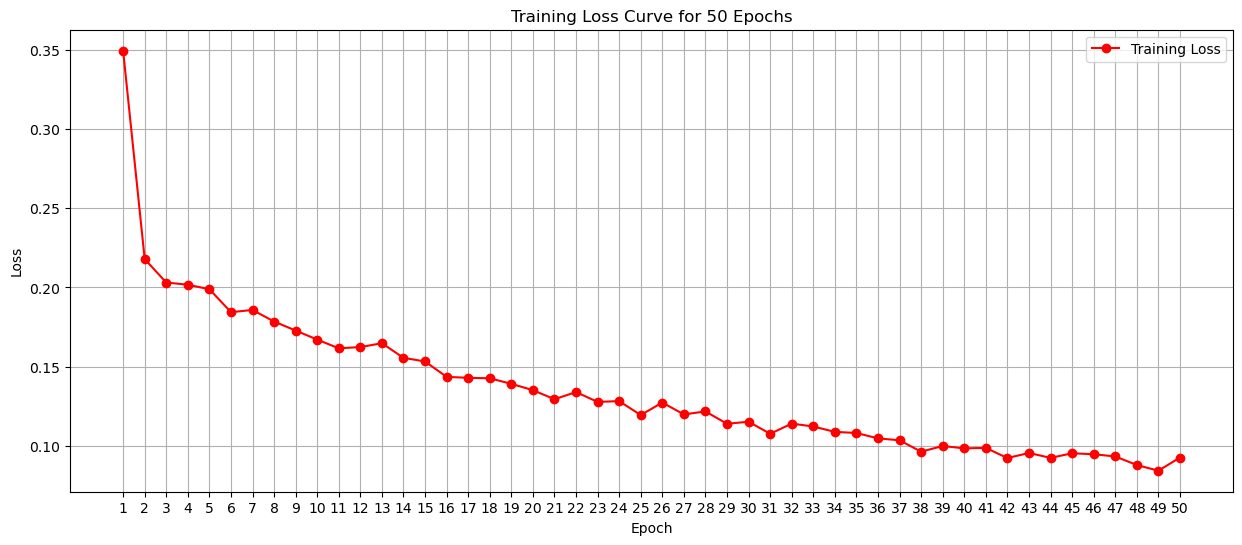

In [283]:

plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')  # Plot the training loss with epoch count
plt.title('Training Loss Curve for 50 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.xticks(range(len(loss_list)), range(1, 1+len(loss_list)))  # Ensure x-axis labels match epoch numbers
plt.legend()  # Show legend to identify the curve
plt.grid(True)
plt.legend() 

plt.show()  # Display the plot

#### ------ End ------ ####

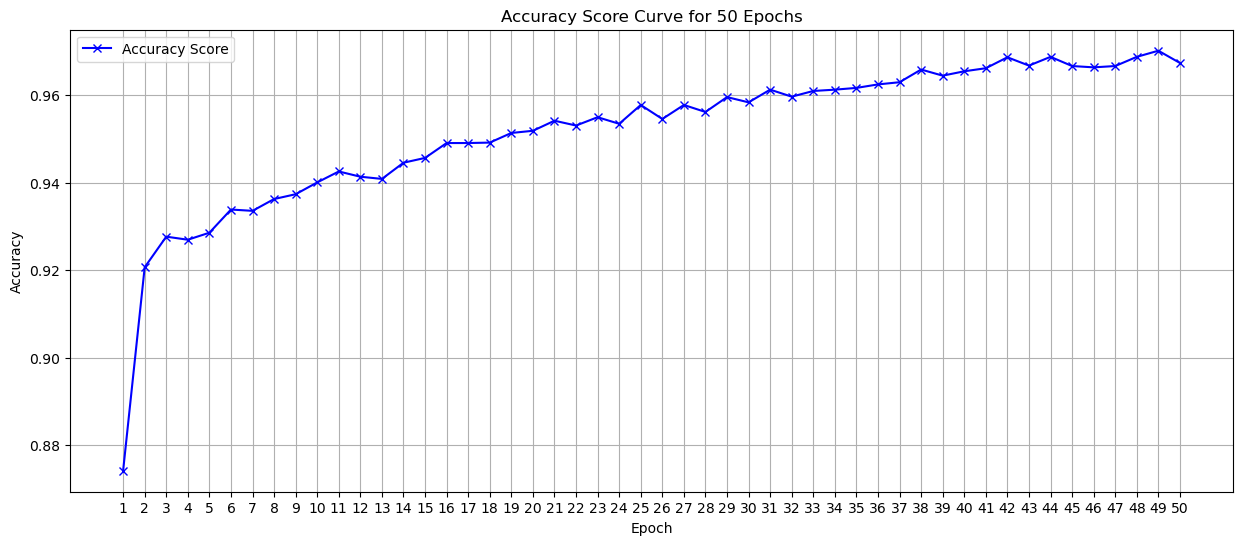

In [284]:


# Assuming 'acc_list' contains the accuracy for each epoch
plt.figure(figsize=(15, 6))  # Set the figure size for better readability
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')# Plot the training accuracy with epoch count
plt.title('Accuracy Score Curve for 50 Epochs')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))  # Ensure x-axis labels match epoch numbers
plt.legend() 
plt.grid(True)  
plt.show()  # Display the plot


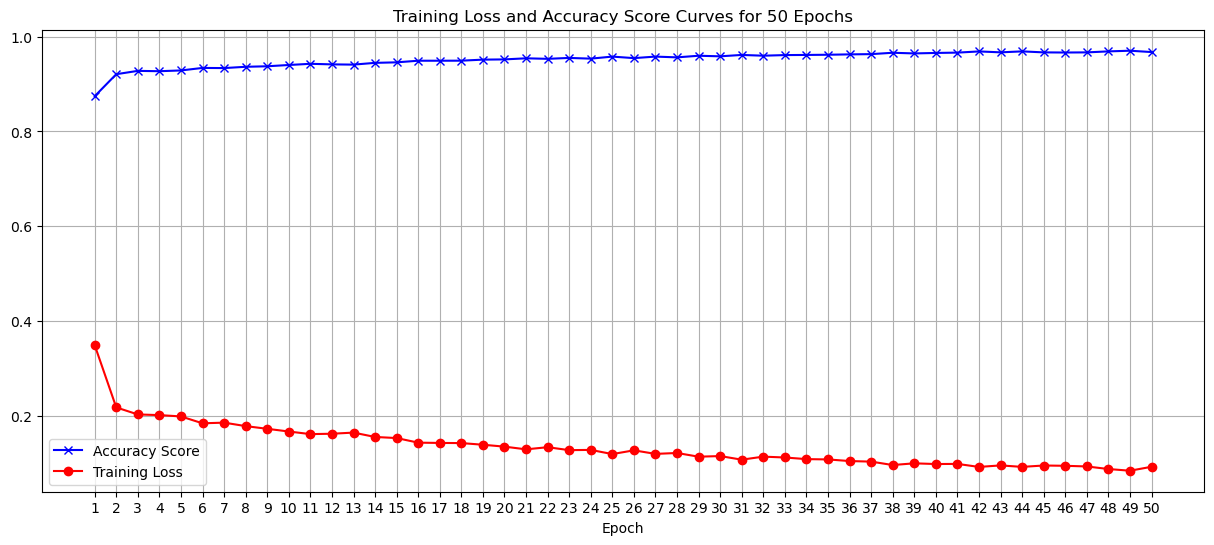

In [285]:
# Plotting Loss and Accuracy Score together
plt.figure(figsize=(15, 6))
plt.title('Training Loss and Accuracy Score Curves for 50 Epochs')
plt.plot(acc_list, label='Accuracy Score', marker='x', color='b')
plt.plot(loss_list, label='Training Loss', marker='o', color = 'r')
plt.xticks(range(len(acc_list)), range(1, 1+len(acc_list)))
plt.xlabel('Epoch')
plt.legend() 
plt.grid(True)  
plt.show()

In [286]:
torch.save(model.state_dict(),"bert.pth")
!du -sh bert.pth

37M	bert.pth
